Dataset URL : https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor  

# Loading Data

In [2]:
df = pd.read_csv("../input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [4]:
df = df.drop("gameId", axis=1)

In [5]:
df.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

# Data Cleaning

In [6]:
df2 = df.copy()

In [7]:
df2.corr()["blueWins"].abs().sort_values(ascending=False)

blueWins                        1.000000
redGoldDiff                     0.511119
blueGoldDiff                    0.511119
redExperienceDiff               0.489558
blueExperienceDiff              0.489558
blueTotalGold                   0.417213
blueGoldPerMin                  0.417213
redTotalGold                    0.411396
redGoldPerMin                   0.411396
blueTotalExperience             0.396141
redTotalExperience              0.387588
blueAvgLevel                    0.357820
redAvgLevel                     0.352127
blueDeaths                      0.339297
redKills                        0.339297
blueKills                       0.337358
redDeaths                       0.337358
blueAssists                     0.276685
redAssists                      0.271047
blueCSPerMin                    0.224909
blueTotalMinionsKilled          0.224909
blueEliteMonsters               0.221944
redEliteMonsters                0.221551
blueDragons                     0.213768
redTotalMinionsK

1. Blue Deaths = Red Kills.
2. Red Deaths = Blue Kills.
3. All "diff" columns are redundant. We can keep just one of each pair. (We can observe same correlation value).
4. "perMin" based features can be paired to create a single "diff" column.
5. We can observe that correlation of perMin of features is same as correlation total of item (Gold, CS (minion kill)). So we drop the perMin parts.
6. One team has first blood, so the other can't have it.

In [8]:
to_drop = [
    "redGoldDiff",
    "blueGoldDiff",
    "redExperienceDiff",
    "blueExperienceDiff",
    "redFirstBlood", 
    "redGoldPerMin", 
    "blueGoldPerMin", 
    "blueCSPerMin", 
    "redCSPerMin", 
    "redDeaths", 
    "redKills",
    "redAssists",
    "blueAssists"
]
df2 = df.drop(to_drop, axis = 1)

Converting the rest of the stats to maybe a good way to reduce dimensionality, because the essence of the game is to perform better than the other team. So "diff" based features should be more meaningful.

In [9]:
diffFeatures = [
    "TotalGold", 
    "TotalExperience", 
    "AvgLevel",
    "TotalMinionsKilled",
    "EliteMonsters",
    "Dragons",
    "TotalJungleMinionsKilled",
    "TowersDestroyed",
    "Heralds",
    "WardsDestroyed",
    "WardsPlaced"
]

for i in diffFeatures :
    df2[i+"Diff"] = df["blue"+i] - df["red"+i]

Let's verify if it actually worked

In [10]:
temp = []
c = df2.corr()["blueWins"]
for i in diffFeatures : 
    temp.append((i, c["blue"+i], c["red"+i], c[i+"Diff"], c[i+"Diff"] > max(abs(c["blue"+i]), abs(c["red"+i]))))

temp = pd.DataFrame(temp, columns = ["feature", "blue corr", "red corr", "diff corr", "better?"])
temp

,feature,blue corr,red corr,diff corr,better?
0,TotalGold,0.417213,-0.411396,0.511119,True
1,TotalExperience,0.396141,-0.387588,0.489558,True
2,AvgLevel,0.357820,-0.352127,0.452927,True
3,TotalMinionsKilled,0.224909,-0.212171,0.309126,True
4,EliteMonsters,0.221944,-0.221551,0.259969,True
5,Dragons,0.213768,-0.209516,0.234264,True
6,TotalJungleMinionsKilled,0.131445,-0.110994,0.169118,True
7,TowersDestroyed,0.115566,-0.103696,0.156179,True
8,Heralds,0.092385,-0.097172,0.121713,True
9,WardsDestroyed,0.044247,-0.055400,0.075205,True


Looks promising, in 10/11 cases, the diff worked better than the individual data. As an approximation, I'll consider all diffs and drop the original columns. This will reduce 11 columns (22 removed, 11 added).

In [11]:
to_drop = []
for i in diffFeatures : 
    to_drop.append("blue"+i)
    to_drop.append("red"+i)

df2 = df2.drop(to_drop, axis=1)

In [12]:
df2.corr()["blueWins"].abs().sort_values(ascending=False)

blueWins                        1.000000
TotalGoldDiff                   0.511119
TotalExperienceDiff             0.489558
AvgLevelDiff                    0.452927
blueDeaths                      0.339297
blueKills                       0.337358
TotalMinionsKilledDiff          0.309126
EliteMonstersDiff               0.259969
DragonsDiff                     0.234264
blueFirstBlood                  0.201769
TotalJungleMinionsKilledDiff    0.169118
TowersDestroyedDiff             0.156179
HeraldsDiff                     0.121713
WardsDestroyedDiff              0.075205
WardsPlacedDiff                 0.016890
Name: blueWins, dtype: float64

Let's check for correlation between features.

<AxesSubplot:>

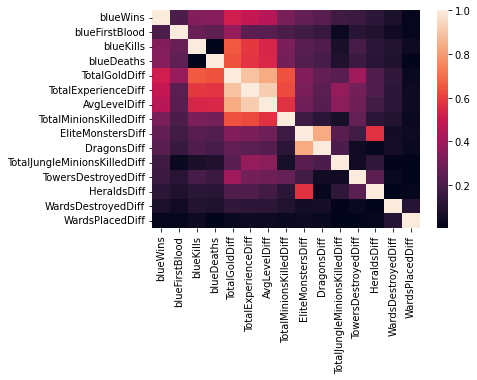

In [13]:
sns.heatmap(df2.corr().abs())

There seem to be some features that are highly correlated among each other : 
1. a 3x3 highlight (TotalGoldDiff, TotalExperienceDiff, AvgLevelDiff)
2. a 2x2 highlight (EliteMonstersDiff, DragonsDiff)

We can try eliminating them using Variance Inflation Factor (VIF).

In [14]:
def get_vif_info(df) :
    df2 = df.copy()
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
    vif_info['Column'] = df2.columns
    return vif_info.sort_values('VIF', ascending=False)

get_vif_info(df2)

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Column
8,inf,EliteMonstersDiff
9,inf,DragonsDiff
12,inf,HeraldsDiff
2,36.057716,blueKills
3,35.350816,blueDeaths
4,20.701543,TotalGoldDiff
5,12.273297,TotalExperienceDiff
6,6.499939,AvgLevelDiff
7,2.951523,TotalMinionsKilledDiff
0,2.454974,blueWins


We can see a huge (infinite) correlation between Dragon, Herald and Elite Monsters. On further inspection, we see that 

Elite monster = Dragons and Heralds.

So we drop the Elite monsters column.

In [15]:
get_vif_info(df2.drop(["EliteMonstersDiff"], axis=1))

,VIF,Column
2,36.057716,blueKills
3,35.350816,blueDeaths
4,20.701543,TotalGoldDiff
5,12.273297,TotalExperienceDiff
6,6.499939,AvgLevelDiff
7,2.951523,TotalMinionsKilledDiff
0,2.454974,blueWins
1,2.300345,blueFirstBlood
9,1.773969,TotalJungleMinionsKilledDiff
10,1.533042,TowersDestroyedDiff


With the abnomalities gone, we can proceed with modelling.

# Prediction

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot

In [17]:
sc = StandardScaler()
X, y = df2.drop(["blueWins"], axis=1), df2["blueWins"]
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [18]:
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
print(f"Training accurcay : {LRmodel.score(X_train, y_train)}")
print(f"Testing accurcay : {LRmodel.score(X_test, y_test)}")

Training accurcay : 0.7320886289506242
Testing accurcay : 0.728744939271255


Checking importance of features

Feature: blueFirstBlood, Score: 0.049
Feature: blueKills, Score: -0.151
Feature: blueDeaths, Score: 0.119
Feature: TotalGoldDiff, Score: 1.235
Feature: TotalExperienceDiff, Score: 0.456
Feature: AvgLevelDiff, Score: 0.029
Feature: TotalMinionsKilledDiff, Score: -0.137
Feature: EliteMonstersDiff, Score: 0.131
Feature: DragonsDiff, Score: 0.173
Feature: TotalJungleMinionsKilledDiff, Score: -0.016
Feature: TowersDestroyedDiff, Score: -0.094
Feature: HeraldsDiff, Score: -0.020
Feature: WardsDestroyedDiff, Score: 0.010
Feature: WardsPlacedDiff, Score: -0.008


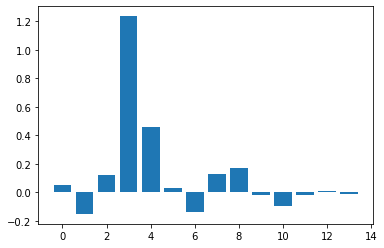

In [19]:
fi_data = []
importance = LRmodel.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0s, Score: %.3f' % (df2.columns[i+1],v))
    fi_data.append((df2.columns[i+1],v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [20]:
fi_data = sorted(fi_data, key=lambda x : -x[1])
fi_data

[('TotalGoldDiff', 1.2348403359931959),
 ('TotalExperienceDiff', 0.45595299560202734),
 ('DragonsDiff', 0.17327780232174747),
 ('EliteMonstersDiff', 0.13136495295170766),
 ('blueDeaths', 0.11851854735725),
 ('blueFirstBlood', 0.04877656137932309),
 ('AvgLevelDiff', 0.029177654536421935),
 ('WardsDestroyedDiff', 0.009779392894476593),
 ('WardsPlacedDiff', -0.008213074976627325),
 ('TotalJungleMinionsKilledDiff', -0.015927097257048294),
 ('HeraldsDiff', -0.02038458389223137),
 ('TowersDestroyedDiff', -0.093888178757483),
 ('TotalMinionsKilledDiff', -0.13746289865032357),
 ('blueKills', -0.15107177105190006)]

Based on the experiments, this is the order of importance to give to the game in the first 10 minutes to have a ~70% chance of winning.